In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import Image

from sktime.datasets import make_causal_pricing
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series

## Data

### Loading the dataset

In [2]:
# We use the default parameters to load the dataset
n_series = 3
n_timepoints = 100
n_categories_d = 45
n_categories_k = 15
random_state = 43

np.random.seed(random_state)

X, y, ground_truth = make_causal_pricing(
    n_series=n_series,
    n_timepoints=n_timepoints,
    n_categories_d=n_categories_d,
    n_categories_k=n_categories_k,
    random_state=random_state,
    return_ground_truth=True,
)

print("Shapes:", X.shape, y.shape)

Shapes: (300, 7) (300, 1)


In [3]:
X.head()

discount        stock  week_number   d  k  promotion  \
article_id time                                                         
0          0          0.0  3672.429665            0  23  0          0   
           1          0.0  3613.057265            1  23  0          0   
           2          0.0  3555.311680            2  23  0          0   
           3          0.0  3516.299445            3  23  0          0   
           4          0.0  3471.642744            4  23  0          0   

                        p0  
article_id time             
0          0     38.939378  
           1     38.939378  
           2     38.939378  
           3     38.939378  
           4     38.939378

In [4]:
y.head()

demand
article_id time           
0          0     59.372400
           1     57.745585
           2     39.012235
           3     44.656701
           4     34.814844

### Exploring Ground Truth

In [5]:
ground_truth.keys()

dict_keys(['treatment_effects', 'base_demand', 'causal_dag', 'metadata'])

In [6]:
ground_truth["treatment_effects"].head()

article_id
0   -2.584352
1   -2.888929
2   -1.358777
Name: treatment_effect, dtype: float64

In [7]:
ground_truth["base_demand"].head()

base_demand
article_id time             
0          0      160.005462
           1      158.378648
           2      139.645297
           3      145.289763
           4      135.447907

In [8]:
ground_truth["metadata"]

{'n_series': 3,
 'n_timepoints': 100,
 'n_categories_d': 45,
 'n_categories_k': 15,
 'reference': 'Schultz et al. (2024), arXiv:2312.15282',
 'random_state': 43,
 'causal_structure': 'q_it = q^b_it + p_it * e_i',
 'treatment_variable': 'price',
 'outcome_variable': 'demand',
 'heterogeneous_effects': True}

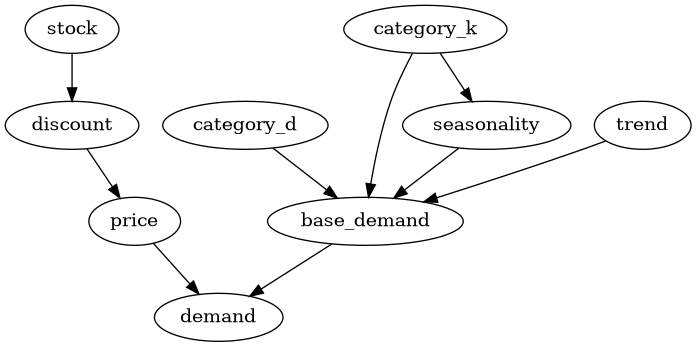

In [9]:
G = ground_truth["causal_dag"]

viz = G.to_graphviz()
viz.draw("causal_forecasting.png", prog="dot")
Image("causal_forecasting.png")

## Exploratory Data Analysis

### 1. Quick Sanity Checks
Check ranges, missing values, and distribution shapes.


Describing X
         discount         stock  week_number           d           k  \
count  300.000000    300.000000   300.000000  300.000000  300.000000   
mean     0.269333   4773.156580    49.500000   12.333333    4.000000   
std      0.201979   4382.127708    28.914301    7.599214    4.974853   
min      0.000000      0.000000     0.000000    6.000000    0.000000   
25%      0.000000    879.464266    24.750000    6.000000    0.000000   
50%      0.300000   3329.081132    49.500000    8.000000    1.000000   
75%      0.500000   8423.678613    74.250000   23.000000   11.000000   
max      0.500000  14578.334783    99.000000   23.000000   11.000000   

        promotion          p0  
count  300.000000  300.000000  
mean     0.666667   35.334649  
std      0.472192   17.922096  
min      0.000000   11.842408  
25%      0.000000   11.842408  
50%      1.000000   38.939378  
75%      1.000000   55.222161  
max      1.000000   55.222161  

Describing y
           demand
count  300.000000


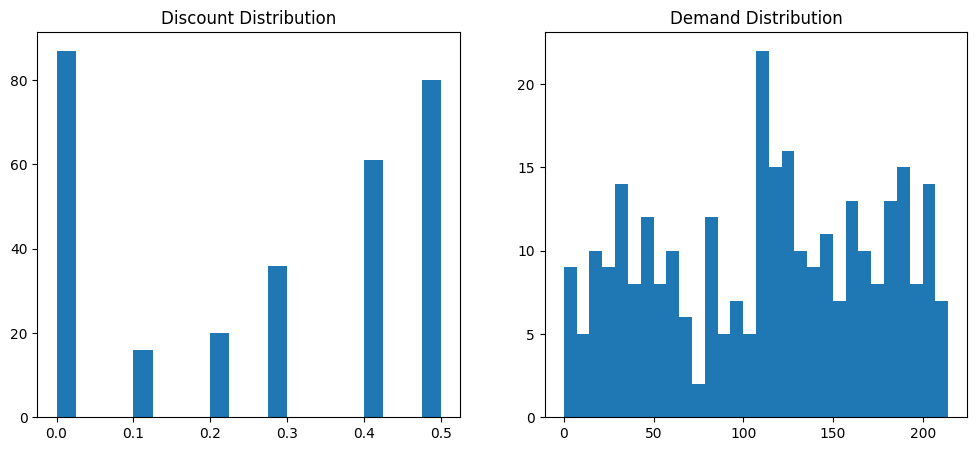

In [10]:
print("Describing X")
print(X.describe())
print("\nDescribing y")
print(y.describe())

# Histograms
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(X["discount"], bins=20)
plt.title("Discount Distribution")

plt.subplot(1, 2, 2)
plt.hist(y["demand"], bins=30)
plt.title("Demand Distribution")
plt.show()

### 2. Select 5 Random Articles (Fixed for whole notebook)

In [11]:
unique_ids = X.index.get_level_values("article_id").unique()
size = 5

if len(unique_ids) <= size:
    sample_ids = unique_ids
else:
    sample_ids = np.random.choice(unique_ids, size=5, replace=False)

sample_ids = sample_ids.sort_values()
sample_ids

Index([0, 1, 2], dtype='int64', name='article_id')

### 3. Demand Over Time for Selected Articles

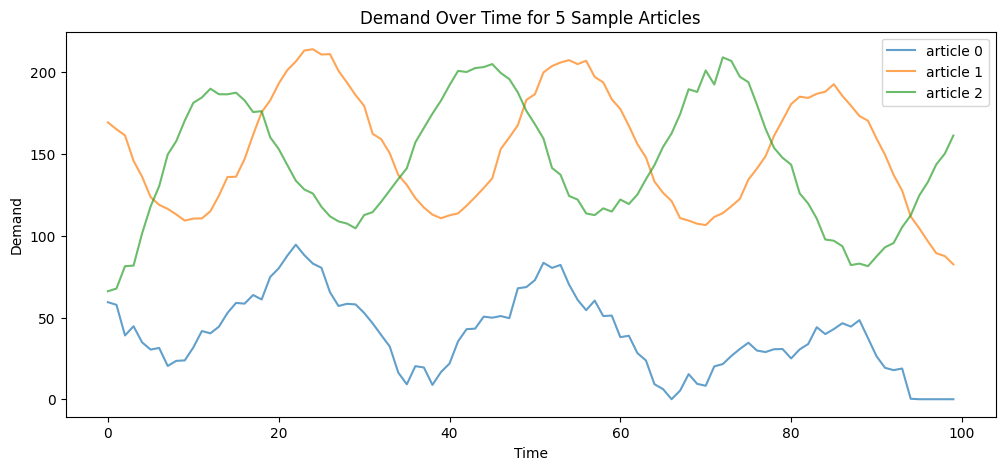

In [12]:
plt.figure(figsize=(12, 5))
for i in sample_ids:
    series = y.loc[i]["demand"]
    plt.plot(series.index, series.values, label=f"article {i}", alpha=0.7)

plt.title("Demand Over Time for 5 Sample Articles")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.legend()
plt.show()

### 4. Stock / Discount / Demand Evolution for a Single Article
This helps visualize the pricing policy reacting to stock.


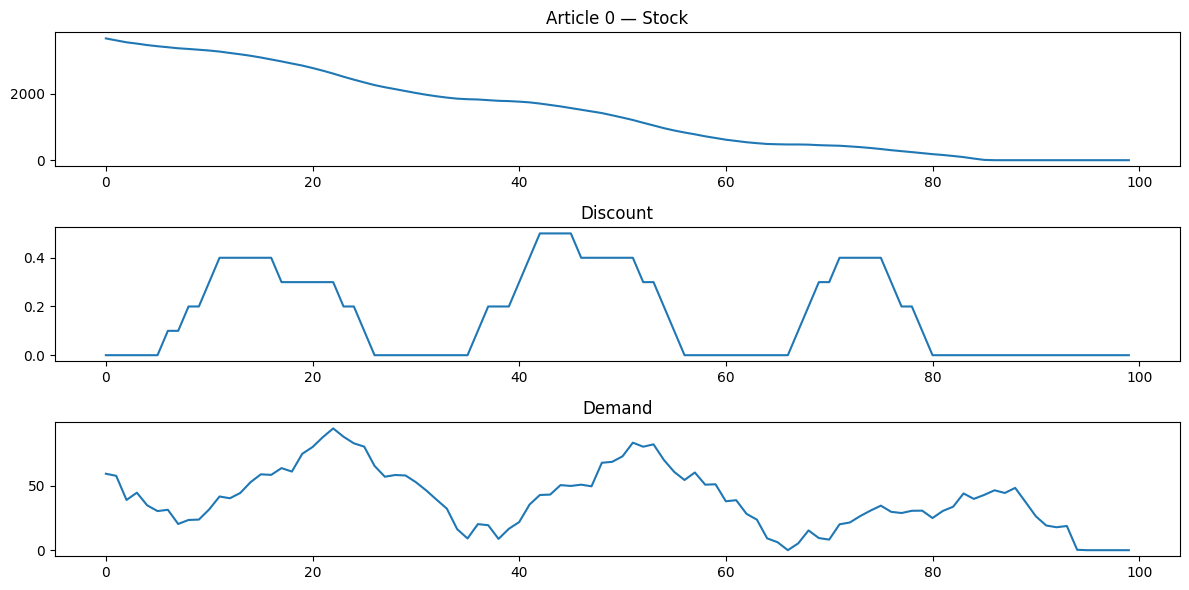

In [13]:
chosen = sample_ids[0]
sub = X.loc[chosen].join(y.loc[chosen])

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(sub.index, sub["stock"])
plt.title(f"Article {chosen} — Stock")

plt.subplot(3, 1, 2)
plt.plot(sub.index, sub["discount"])
plt.title("Discount")

plt.subplot(3, 1, 3)
plt.plot(sub.index, sub["demand"])
plt.title("Demand")
plt.tight_layout()
plt.show()

### 5. Discount → Demand Relationship
For articles pooled (dense, but confirms negative slope).

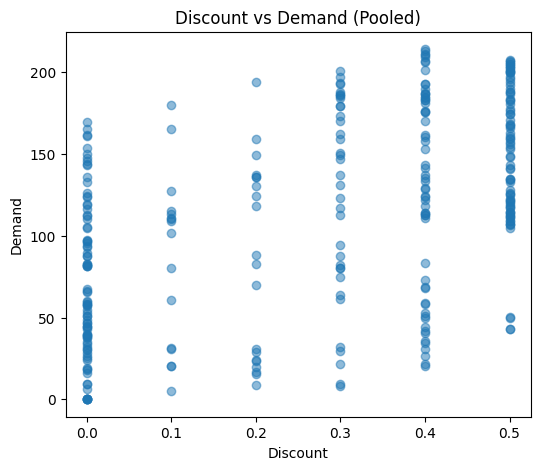

In [14]:
plt.figure(figsize=(6, 5))
plt.scatter(X.loc[sample_ids]["discount"], y["demand"].loc[sample_ids], alpha=0.5)
plt.xlabel("Discount")
plt.ylabel("Demand")
plt.title("Discount vs Demand (Pooled)")
plt.show()

### 6. Category Effects on Demand (Brand `d` and Group `k`)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


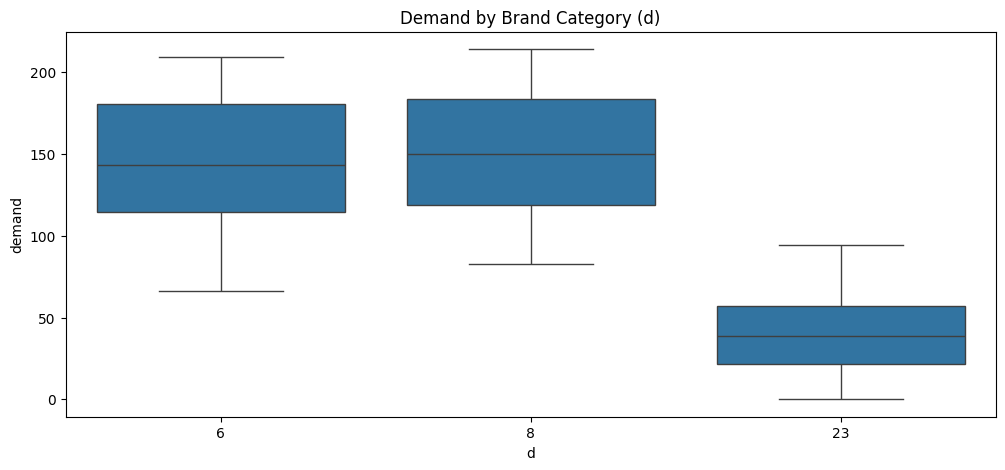

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


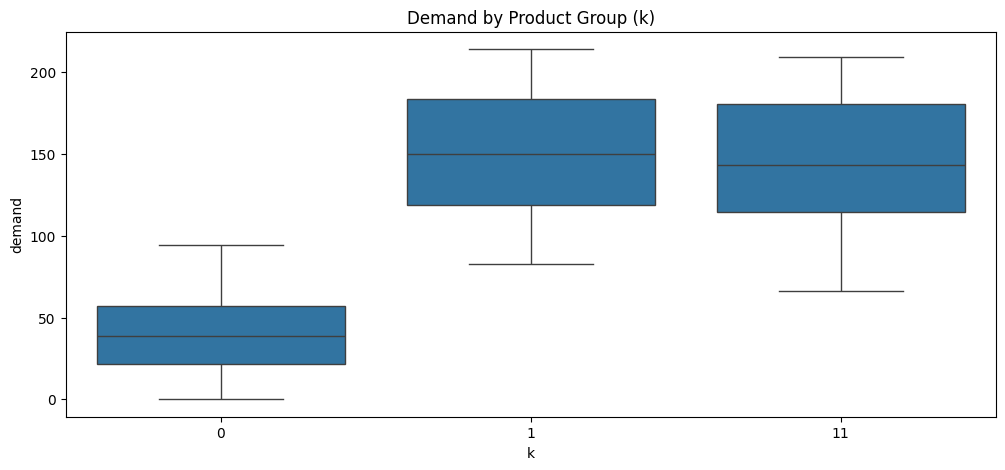

In [15]:
plt.figure(figsize=(12, 5))
sns.boxplot(x=X["d"], y=y["demand"])
plt.title("Demand by Brand Category (d)")
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x=X["k"], y=y["demand"])
plt.title("Demand by Product Group (k)")
plt.show()

### 7. Seasonality Check - Average Demand by Week Number


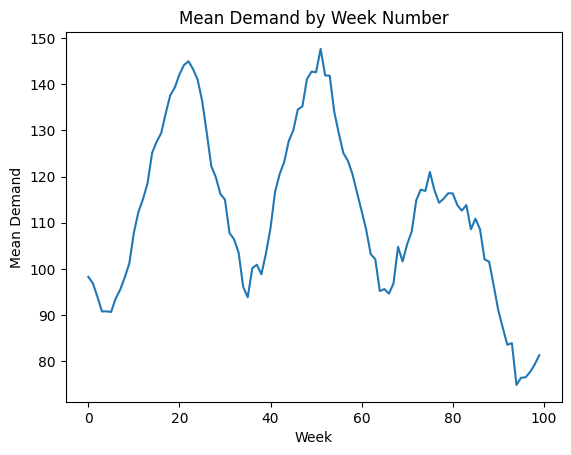

In [16]:
mean_by_week = y["demand"].groupby(X["week_number"]).mean()
plt.plot(mean_by_week.index, mean_by_week.values)
plt.title("Mean Demand by Week Number")
plt.xlabel("Week")
plt.ylabel("Mean Demand")
plt.show()

# Forecasting: WIP

- without exogenous
- with exogenous
- with exogenous + exposure variable
- with oos

In [ ]:
def plot_samples(y_train, y_test, preds, sample_ids=None, width=14, height=4):
    """Plot time series samples with predictions."""
    if sample_ids is None:
        sample_ids = y_train.index.get_level_values("article_id").unique()

    for aid in sample_ids:
        fig, ax = plt.subplots(figsize=(width, height))

        plot_series(
            y_train.loc[aid],
            y_test.loc[aid],
            preds.loc[aid],
            labels=["Train", "Test", "Prediction"],
            ax=ax,
        )

        ax.set_title(f"Article ID: {aid}", fontsize=14, pad=10)
        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)

        plt.tight_layout()
        plt.show()

In [18]:
test_size = 0.2
window_length = 10
fh = list(range(1, int(test_size * n_timepoints) + 1))

fh

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [19]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=test_size)

In [20]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

from sktime.datasets import make_causal_pricing
from sktime.forecasting.causal import DoubleMLForecaster
from sktime.forecasting.compose import BaggingForecaster, make_reduction
from sktime.split import temporal_train_test_split
from sktime.transformations.bootstrap import STLBootstrapTransformer

In [21]:
from sklearn.metrics import mean_absolute_error

from sktime.forecasting.croston import Croston

In [ ]:
"""
BaggingForecaster:     insample,    X,    ensemble
Croston:               insample, no-X, no-ensemble
NaiveForecaster:       insample, no-X, no-ensemble
make_reduction:     no-insample,    X, no-ensemble

outcome_fcst and treatment_fcst must support in-sample predictions
any one component should support exog
"""

# outcome_fcst = BaggingForecaster(
# 	STLBootstrapTransformer(sp=3),
# 	NaiveForecaster(sp=12)
# )
# outcome_fcst = NaiveForecaster(sp=12)
# outcome_fcst = Croston()
outcome_fcst = make_reduction(RandomForestRegressor(), window_length=window_length)

(
    outcome_fcst.get_tag("capability:insample"),
    outcome_fcst.get_tag("capability:exogenous"),
)

(False, True)

no-X / no-exp / no-oos

Mean Absolute Error: 22.7676


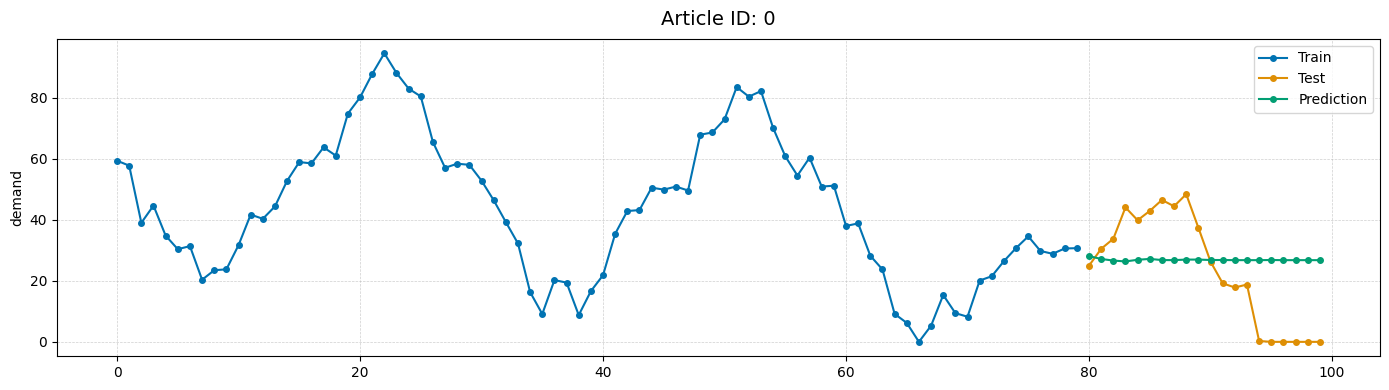

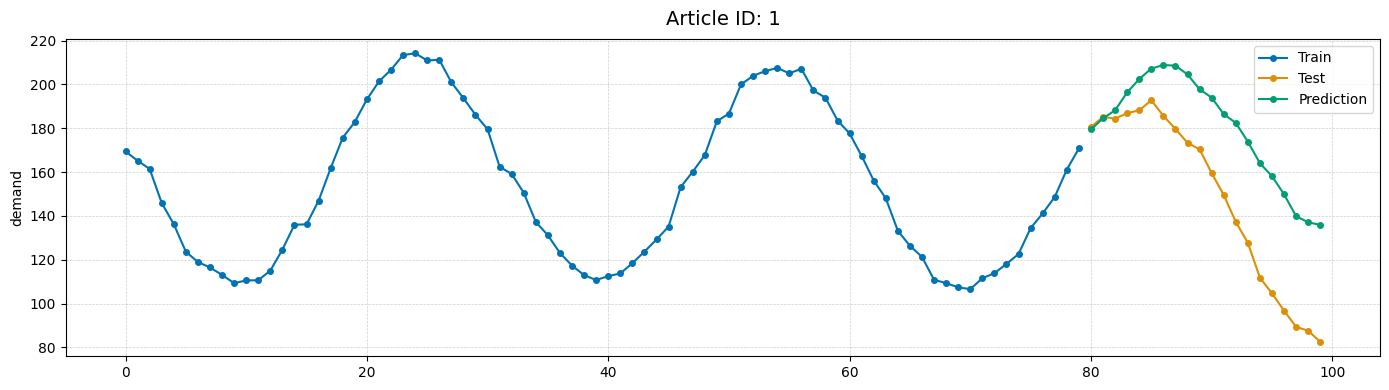

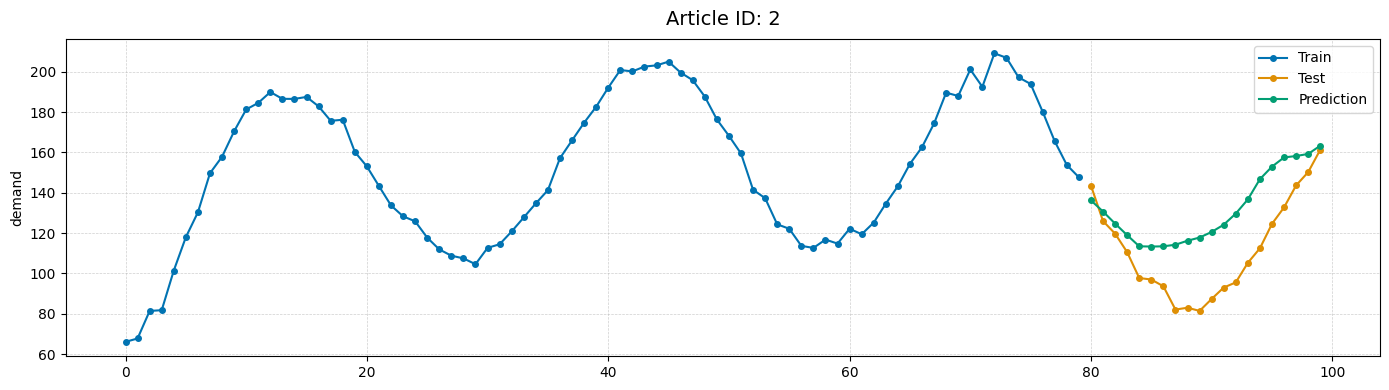

In [24]:
outcome_fcst = BaggingForecaster(STLBootstrapTransformer(sp=8), Croston(smoothing=0.1))
treatment_fcst = BaggingForecaster(
    STLBootstrapTransformer(sp=8), Croston(smoothing=0.1)
)
residual_fcst = make_reduction(RandomForestRegressor(), window_length=window_length)

dml_forecaster = DoubleMLForecaster(
    outcome_fcst=outcome_fcst,
    treatment_fcst=treatment_fcst,
    residual_fcst=residual_fcst,
)

dml_forecaster.fit(y=y_train, fh=fh)
preds = dml_forecaster.predict()
mae = mean_absolute_error(y_test, preds)

print(f"Mean Absolute Error: {mae:.4f}")
plot_samples(y_train, y_test, preds, sample_ids=sample_ids)

X / no-exp / no-oos

Mean Absolute Error: 24.2387


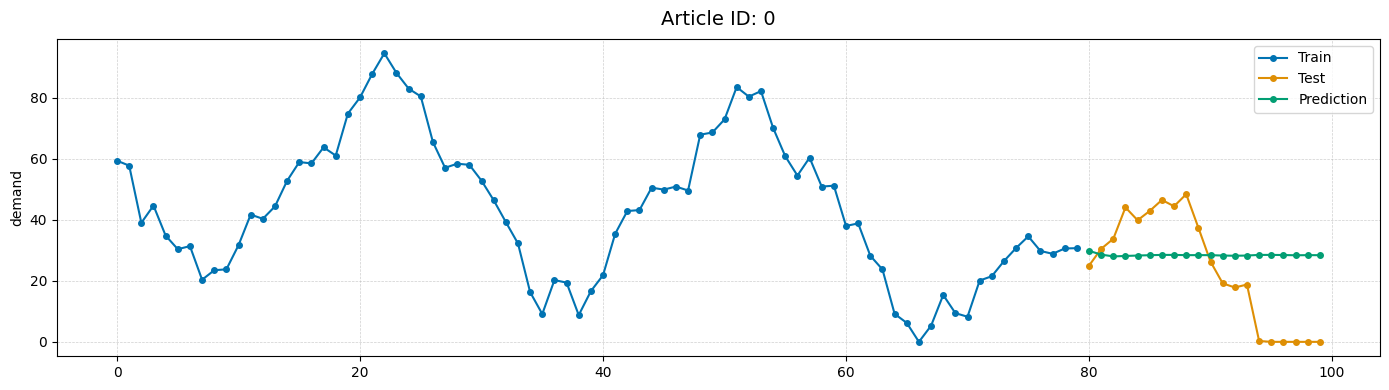

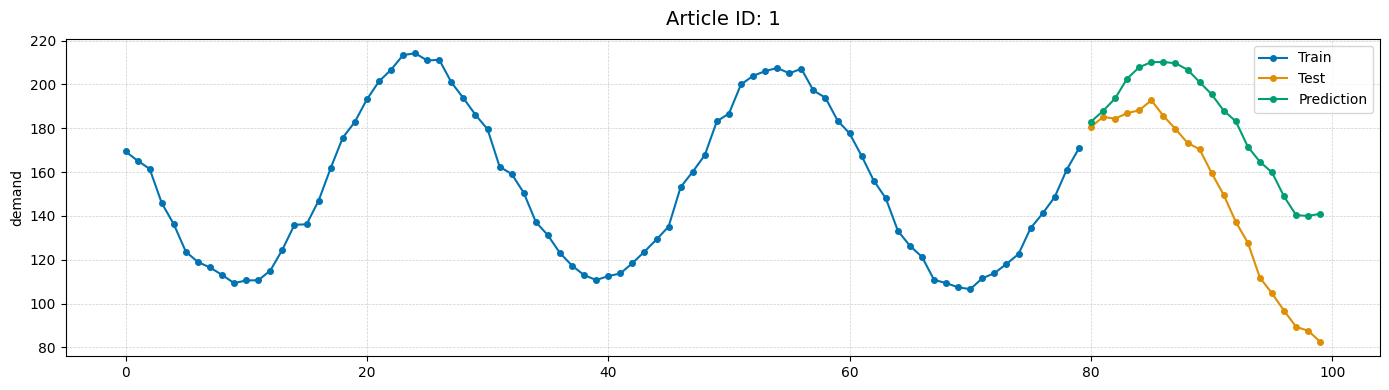

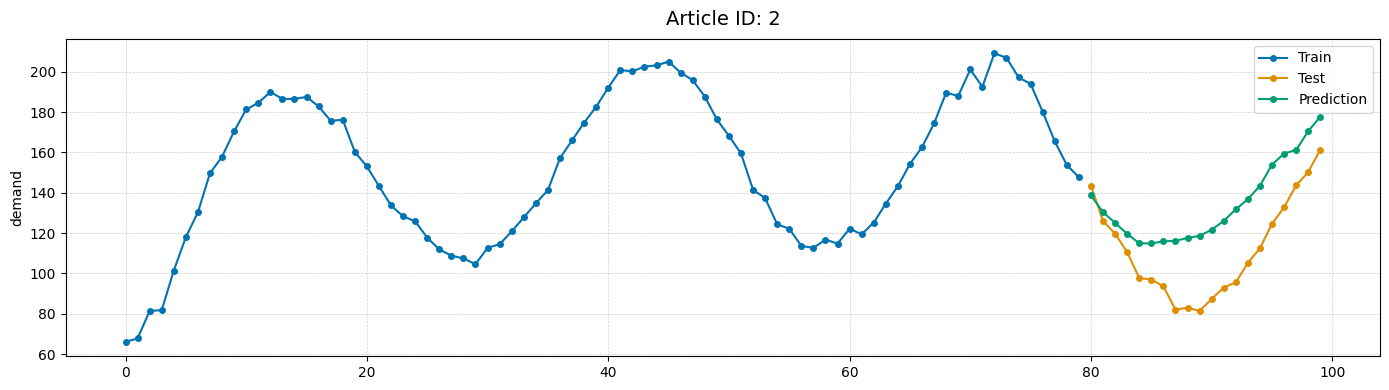

In [25]:
outcome_fcst = BaggingForecaster(STLBootstrapTransformer(sp=8), Croston(smoothing=0.1))
treatment_fcst = BaggingForecaster(
    STLBootstrapTransformer(sp=8), Croston(smoothing=0.1)
)
residual_fcst = make_reduction(RandomForestRegressor(), window_length=window_length)

dml_forecaster = DoubleMLForecaster(
    outcome_fcst=outcome_fcst,
    treatment_fcst=treatment_fcst,
    residual_fcst=residual_fcst,
)

dml_forecaster.fit(y=y_train, X=X_train, fh=fh)
preds = dml_forecaster.predict(X=X_test)
mae = mean_absolute_error(y_test, preds)

print(f"Mean Absolute Error: {mae:.4f}")
plot_samples(y_train, y_test, preds, sample_ids=sample_ids)

In [26]:
outcome_fcst = BaggingForecaster(STLBootstrapTransformer(sp=8), Croston(smoothing=0.1))
treatment_fcst = BaggingForecaster(
    STLBootstrapTransformer(sp=8), Croston(smoothing=0.1)
)
residual_fcst = make_reduction(RandomForestRegressor(), window_length=window_length)

dml_forecaster = DoubleMLForecaster(
    outcome_fcst=outcome_fcst,
    treatment_fcst=treatment_fcst,
    residual_fcst=residual_fcst,
    exposure_vars=["p0"],
)

dml_forecaster.fit(y=y_train, X=X_train, fh=fh)
preds = dml_forecaster.predict(X=X_test)
mae = mean_absolute_error(y_test, preds)

print(f"Mean Absolute Error: {mae:.4f}")
plot_samples(y_train, y_test, preds, sample_ids=sample_ids)

BracketError: The algorithm terminated without finding a valid bracket. Consider trying different initial points.